In [9]:
import json
import os

import numpy as np
from matplotlib import pyplot as plt

from snn.layers import SCTNLayer
from snn.spiking_network import SpikingNetwork
from snn.spiking_neuron import create_SCTN, IDENTITY
from snn.resonator import test_resonator_on_chirp, freq_of_resonator, lp_by_lf



def neuron_output(neuron, signal_freq, shift_degrees=0, phase_number=20):
    y_events = neuron.out_spikes()
    samples_per_cycle =  clk_freq / signal_freq
    samples_per_degree = samples_per_cycle/360
    shift_samples = int(shift_degrees*samples_per_degree)
    y_events = y_events[
        (y_events > ((phase_number-1)/signal_freq) * clk_freq + shift_samples) &
        (y_events < ((phase_number/signal_freq) * clk_freq) + shift_samples)
    ]
    if len(y_events) == 0:
        return y_events
    # y_events -= int(((phase_number-1)/signal_freq) * clk_freq + shift_samples)
    return y_events

def events_to_spikes(events, run_window=0, spikes_arr_size=-1):
    if spikes_arr_size == -1:
        y_spikes = np.zeros(events[-1] + 1)
    else:
        y_spikes = np.zeros(spikes_arr_size)

    y_spikes[events] = 1
    if run_window == 0:
        return y_spikes

    y_spikes_rollsum = np.convolve(y_spikes, np.ones(run_window, dtype=int), 'valid')
    return y_spikes_rollsum

def amplify_spikes(base_spikes, spikes_window, base_min, base_max, amplify):
    base_spikes = events_to_spikes(base_spikes-resonator_input[0], spikes_arr_size=int(clk_freq/freq0)+1)
    result = np.zeros_like(base_spikes)
    result[np.arange(len(base_spikes)) % 2 == 1] = 1
    dc = (base_max + base_min)/2
    for i in range(spikes_window, len(result), spikes_window):
        slice_spikes = base_spikes[i:i+spikes_window]
        if len(slice_spikes) < spikes_window:
            break
        curr_spikes = np.sum(slice_spikes) - dc
        new_spikes = int(curr_spikes * amplify)

        if new_spikes > 0:
            spikes_ts = np.linspace(0, spikes_window, new_spikes).astype(int)//2*2 + i
            result[spikes_ts] = 1
        else:
            spikes_ts = np.linspace(0, spikes_window, abs(new_spikes)).astype(int)//2*2 - 1 + i
            result[spikes_ts] = 0
    result = np.where(result == 1)[0]
    return result

def smooth(arr, size):
    filter = np.exp(-(np.arange(size) - size//2)**2 / (2 * (size/4)**2))
    normalized_filter = filter / np.sum(filter)
    res = np.convolve(arr, normalized_filter, 'same')
    res[:size] = arr[:size]
    res[-size:] = arr[-size:]
    return res

def argmax(arr):
    return int(.5 * (np.argmax(arr) + len(arr) - np.argmax(arr[::-1]) - 1))

clk_freq = 1536000
freq0 = 305
lf = 4
best_lp = lp_by_lf(lf, freq0, clk_freq)
freq0 = freq_of_resonator(clk_freq, lf, best_lp)

duration = 25 / freq0
x = np.linspace(0, duration, int(duration * clk_freq))
t = x * 2 * np.pi * freq0
sine_wave = np.sin(t)
freq0

305.577490736439

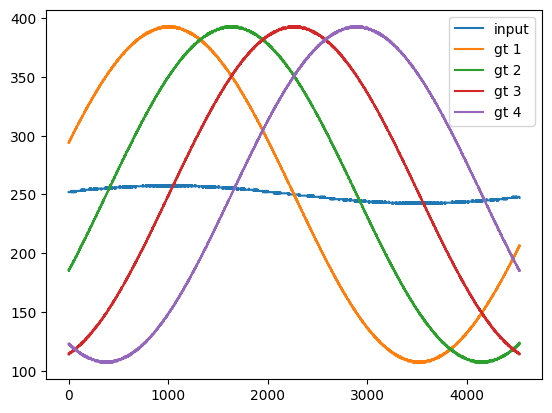

In [10]:
%matplotlib inline

gain = 19
spikes_window = 500
resonator = SpikingNetwork(clk_freq)
resonator.add_amplitude(1000)

# Encode to pdm
neuron = create_SCTN()
neuron.activation_function = IDENTITY
resonator.add_layer(SCTNLayer([neuron]))

wave_length = int(clk_freq/freq0)
resonator.log_out_spikes(-1)
resonator.input_full_data(sine_wave)

resonator_input = neuron_output(resonator.neurons[0], freq0, shift_degrees=0)
rresonator_input = events_to_spikes(resonator_input-resonator_input[0], run_window=spikes_window, spikes_arr_size=int(clk_freq/freq0)+1)

ground_truth = []
phase_shifts = [0] + [45]*3
phase_shifts = np.cumsum(phase_shifts)

gt4stdp = []
for phase_shift_degree in phase_shifts:
    phase_shift = phase_shift_degree/360
    resonator.input_full_data(8*sine_wave[int((1-phase_shift)*wave_length):int((20-phase_shift)*wave_length)])
    resonator.log_out_spikes(-1)
    resonator.forget_logs()

    resonator.input_full_data(gain*sine_wave[int((1-phase_shift)*wave_length):])
    output = neuron_output(resonator.neurons[0], freq0, 0)
    ground_truth.append(output)

    output = neuron_output(resonator.neurons[0], freq0, phase_shift_degree + 45 - phase_shifts[0])
    half_wave = argmax(output[1:][(output[1:] - output[:-1])])
    output = output[:half_wave]
    gt4stdp.append(output)
    
gt1 = ground_truth[0]
gt2 = ground_truth[1]
gt3 = ground_truth[2]
gt4 = ground_truth[3]
rolling_gt = []
plt.plot(rresonator_input, label=f'input')
for i, gt in enumerate(ground_truth):
    rolling_gt.append(events_to_spikes(gt-resonator_input[0], run_window=spikes_window, spikes_arr_size=int(clk_freq/freq0)+1))
    plt.plot(rolling_gt[i], label=f'gt {i+1}')
    
gt_wave_amplitudes = [(o.max(), o.min()) for o in rolling_gt]
peaks = [argmax(rgt) for rgt in rolling_gt]
half_wave = [ground_truth[peak:peak+(wave_length//2)] for peak in peaks]
plt.legend()
plt.show()


In [11]:
def simple_resonator(
        freq0,
        clk_freq,
        lf,
        thetas,
        weights,
):
    LF = lf
    LP = lp_by_lf(LF, freq0, clk_freq)
    network = SpikingNetwork(clk_freq)
    network.add_amplitude(1000)

    # Encode to pdm
    neuron = create_SCTN()
    neuron.activation_function = IDENTITY
    network.add_layer(SCTNLayer([neuron]))

    # SCTN 1
    neuron = create_SCTN()
    neuron.synapses_weights = np.array([weights[0], -weights[1]], dtype=np.float64)
    neuron.leakage_factor = LF
    neuron.leakage_period = LP
    neuron.theta = thetas[0]
    neuron.activation_function = IDENTITY
    neuron.membrane_should_reset = False
    network.add_layer(SCTNLayer([neuron]))

    for i in range(3):
        neuron = create_SCTN()
        neuron.synapses_weights = np.array([weights[2+i]], dtype=np.float64)
        neuron.leakage_factor = LF
        neuron.leakage_period = LP
        neuron.theta = thetas[1+i]
        neuron.activation_function = IDENTITY
        neuron.membrane_should_reset = False
        network.add_layer(SCTNLayer([neuron]))

    # feedback
    network.connect_by_id(4, 1)
    return network

def learning_resonator(
        freq0,
        clk_freq,
        lf,
        thetas,
        weights,
        ground_truths,
        A,
        time_to_learn,
        max_weight,
        min_weight,
):
    network = simple_resonator(freq0, clk_freq, lf, thetas, weights)
    tau = network.clk_freq * time_to_learn / 2
    network.neurons[1].set_supervised_stdp(A, tau, clk_freq, max_weight, min_weight, ground_truths[0])
    for i in range(3):
        network.neurons[2+i].set_supervised_stdp(A, tau, clk_freq, max_weight, min_weight, ground_truths[1 + i])
    return network

def flat_weights(resonator):
    ws = []
    for neuron in resonator.neurons[1:]:
        for w in neuron.synapses_weights:
            ws.append(abs(float(f'{w:.3f}')))
    return np.array(ws)

def flat_thetas(resonator):
    return [float(f'{neuron.theta:.3f}') for neuron in resonator.neurons[1:]]

## Bias + Weights Learning

In [12]:
# chosen_bias=[-1, -5, -5, -5]
# chosen_weights=[11, 9, 10, 10, 10]

# 462
chosen_bias=[-34.686, -43.839, -47.68, -44.168]
chosen_weights=[138.713, 69.379, 87.871, 95.319, 88.389]
(0.6124672032074526, 0.9766487108414832, 0.1430503889076767)

chosen_bias=[
        -10.522,
        -29.397,
        -28.825,
        -30.138
    ]
chosen_weights=[
        75.191,
        54.066,
        58.886,
        57.582,
        60.149
    ]

# for sns algorithm
# chosen_bias=np.array([-0.71, -16.348, -21.148, -20.309]) + 1
# chosen_weights=np.array([47.265, 46.16, 32.94, 42.332, 40.631]) - 2

# 212
# phase 20
# chosen_bias=[-14.783, -22.449, -16.44, -20.524]
# chosen_weights=[ 67.976, 38.323, 44.854, 33.035, 41.028]

# phase 33
# chosen_bias=[-54.832, -25.934, -20.523, -20.433]
# chosen_weights=[129.425, 19.888, 51.957, 40.94, 40.847]

# phase 10
# chosen_bias=[-0.75, -16.406, -21.164, -20.36]
# chosen_weights=[47.392, 45.781, 32.943, 42.209, 40.615]

# chosen_bias=[-54.858, -25.456, -20.265, -20.229]
# chosen_weights=[129.284, 19.639, 50.809, 40.495, 40.55]


In [13]:
resonator = learning_resonator(
    freq0=freq0,
    clk_freq=clk_freq,
    lf=lf,
    thetas=chosen_bias,
    weights=chosen_weights,
    ground_truths=ground_truth,
#     ground_truths=gt4stdp,
    A=2e-4,
    time_to_learn=1e-5,
    max_weight=np.inf,
    min_weight=-np.inf,
)
learning_rules = [neuron.supervised_stdp for neuron in resonator.neurons[1:]]
for i, neuron in enumerate(resonator.neurons):
    resonator.log_out_spikes(i)
    neuron.supervised_stdp = None

momentum_beta = .0

<IPython.core.display.Javascript object>


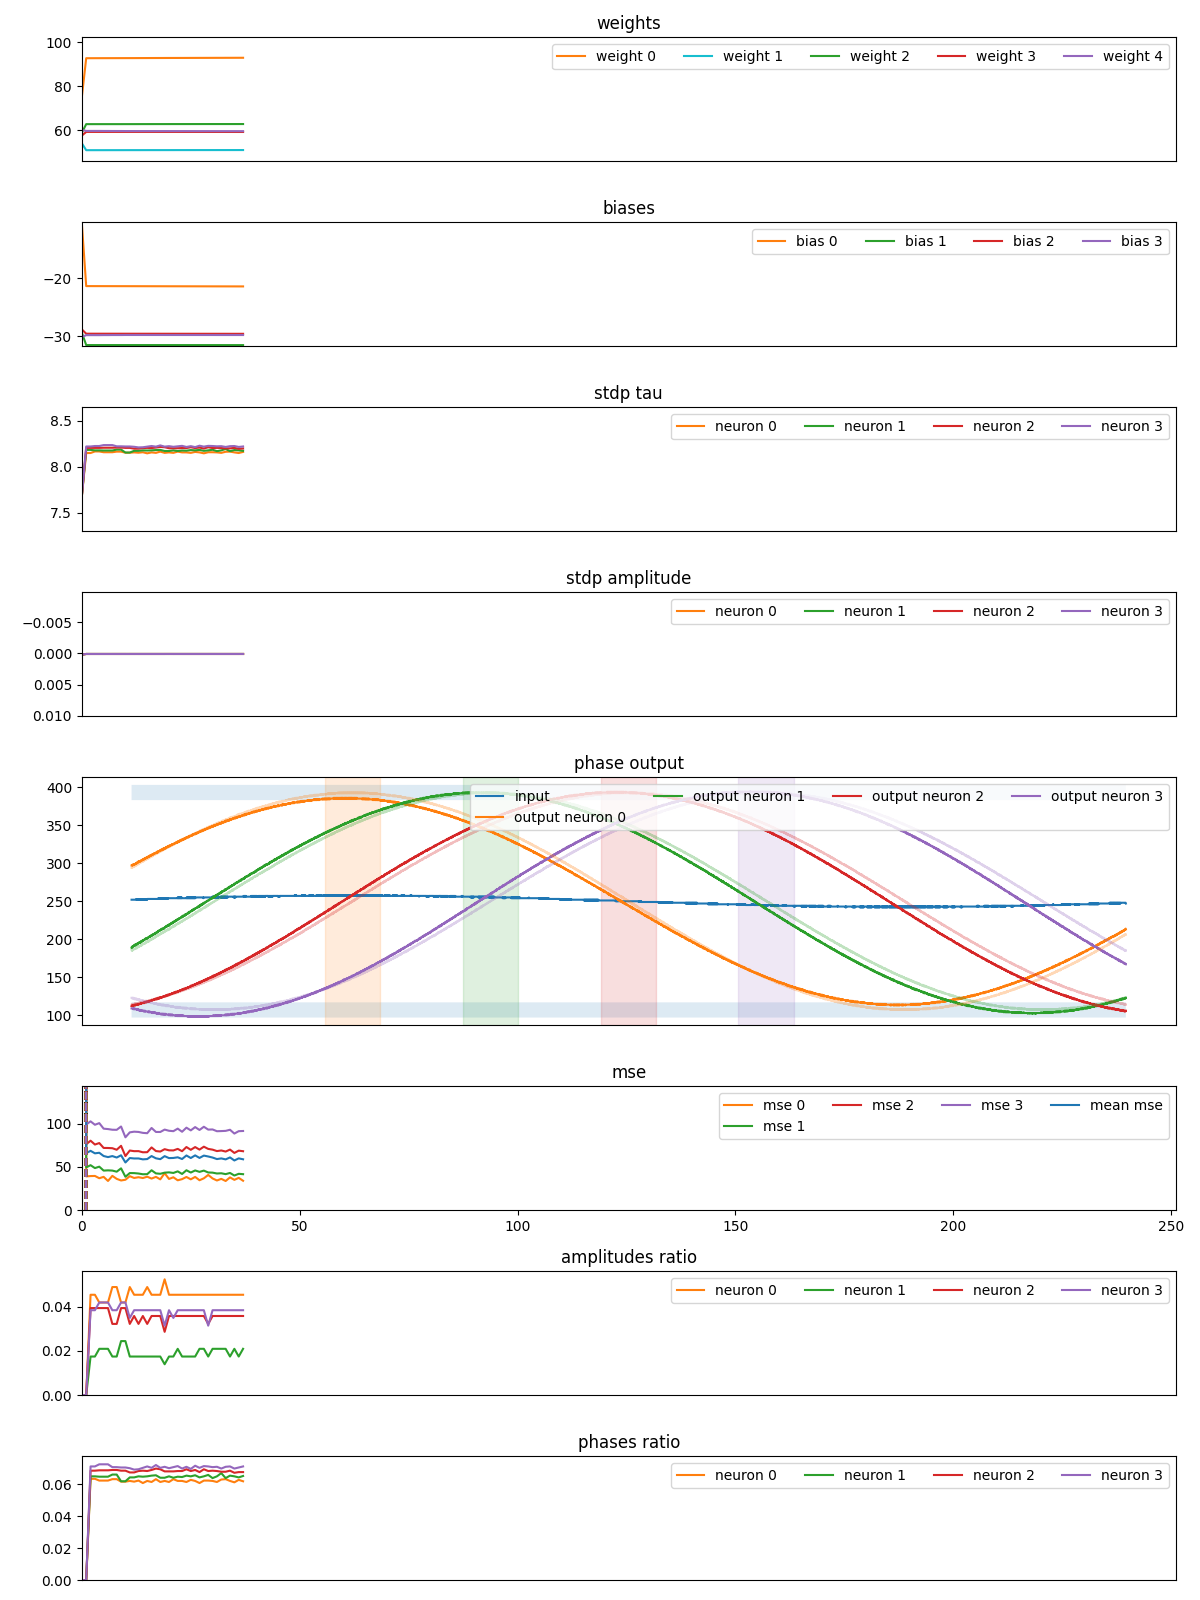

0it [00:00, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_32868\2733564238.py:251: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axs[amplitude_gt_ratio_axs].set_ylim(amplitude_ratio[:i, :].min() * .93, amplitude_ratio[:i, :].max() * 1.07)
C:\Users\User\AppData\Local\Temp\ipykernel_32868\2733564238.py:252: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axs[phase_gt_ratio_axs].set_ylim(phase_ratio[:i, :].min() * .93, phase_ratio[:i, :].max() * 1.07)
7it [00:02,  2.58it/s, weights=[75.743, 54.618, 59.375, 58.075, 60.644], thetas=[-10.798, -29.643, -29.074, -30.387], mse=451, amplitudes=[(366.0, 133.0), (367.0, 132.0), (365.0, 135.0), (368.0, 129.0)], dc=[248.27694346289752, 257.7345406360424, 261.77429328621906, 258.73189045936397], tuned_parameters=4, xi=-5.88] C:\Users\User\AppData\Local\Temp\ipykernel_32868\2733564238.py:251: 

min mse 451.2975927561837
chosen_bias=[-10.776, -29.624, -29.05, -30.362]
chosen_weights=[75.699, 54.574, 59.337, 58.028, 60.595]
xi = -22.982107355864812


498it [03:50,  1.95it/s, weights=[84.696, 51.523, 61.573, 59.096, 61.473], thetas=[-17.699, -31.451, -29.295, -30.596], mse=623, amplitudes=[(391.0, 109.0), (389.0, 95.0), (389.0, 95.0), (393.0, 85.0)], dc=[246.90260600706713, 250.39907243816253, 256.93727915194347, 253.46532685512366], tuned_parameters=1, xi=-12.5]    

min mse 598.4611859540636
chosen_bias=[-17.628, -31.451, -29.295, -30.596]
chosen_weights=[84.548, 51.5, 61.564, 59.106, 61.481]
xi = -13.0417495029821


747it [06:03,  1.80it/s, weights=[89.274, 51.028, 62.109, 59.025, 61.023], thetas=[-19.913, -31.457, -29.353, -30.419], mse=241, amplitudes=[(389.0, 111.0), (391.0, 98.0), (391.0, 99.0), (395.0, 91.0)], dc=[247.83259717314488, 254.12720848056537, 259.884054770318, 256.05609540636044], tuned_parameters=5, xi=-6.28]  

min mse 218.40017667844523
chosen_bias=[-19.873, -31.457, -29.351, -30.418]
chosen_weights=[89.184, 51.024, 62.087, 59.016, 61.019]
xi = -6.282306163021872


996it [08:25,  1.71it/s, weights=[91.393, 51.013, 62.413, 58.895, 60.584], thetas=[-20.769, -31.49, -29.459, -30.292], mse=131, amplitudes=[(389.0, 112.0), (394.0, 100.0), (393.0, 102.0), (395.0, 93.0)], dc=[249.20605123674912, 257.2221731448763, 261.55697879858656, 256.89531802120143], tuned_parameters=6, xi=-4.77]  

min mse 107.37544169611309
chosen_bias=[-20.562, -31.476, -29.423, -30.279]
chosen_weights=[90.984, 50.936, 62.493, 58.928, 60.516]
xi = -4.771371769383691


1183it [10:19,  1.65it/s, weights=[92.364, 50.946, 62.606, 59.252, 59.958], thetas=[-21.232, -31.516, -29.533, -29.891], mse=84.8, amplitudes=[(387.0, 112.0), (392.0, 100.0), (393.0, 103.0), (395.0, 96.0)], dc=[248.47128975265016, 256.7071554770318, 261.88537985865725, 258.01325088339223], tuned_parameters=6, xi=-3.34]

tune
weights [92.356, 50.938, 62.606, 59.252, 59.958]
thetas [-21.228, -31.516, -29.533, -29.891]
mse [45.26810954063604, 68.26280918727915, 98.14134275618375, 122.37566254416961, 83.51198100706713]


1245it [10:57,  1.60it/s, weights=[92.788, 50.938, 62.786, 59.251, 59.699], thetas=[-21.342, -31.526, -29.564, -29.813], mse=66, amplitudes=[(386.0, 113.0), (393.0, 102.0), (394.0, 105.0), (395.0, 98.0)], dc=[248.7416077738516, 257.8577738515901, 262.907906360424, 258.74911660777383], tuned_parameters=8, xi=-2.62]      

min mse 61.41547040636043
chosen_bias=[-21.333, -31.525, -29.561, -29.812]
chosen_weights=[92.754, 50.934, 62.779, 59.254, 59.705]
xi = -2.1471172962226603


1283it [11:22,  1.88it/s, weights=[92.989, 51.002, 62.832, 59.22, 59.589], thetas=[-21.398, -31.534, -29.584, -29.794], mse=63, amplitudes=[(386.0, 113.0), (393.0, 102.0), (394.0, 105.0), (395.0, 98.0)], dc=[249.01523851590105, 258.422703180212, 263.22835689045934, 258.6881625441696], tuned_parameters=8, xi=-2.86]     


In [14]:
%matplotlib notebook
from tqdm import tqdm

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

def_color = '#1f77b4'
colors = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
epochs = 250

weights_axs = 0
bias_axs = 1
phase_axs = 4
stdp_amplitude_axs = 3
stdp_tau_axs = 2
mse_axs = 5
amplitude_gt_ratio_axs = 6
phase_gt_ratio_axs = 7

weights = np.zeros((epochs+1, 5))
weights[0, :] = flat_weights(resonator)

biases = np.zeros((epochs+1, 4))
biases[0, :] = flat_thetas(resonator)

mses = np.ones((epochs+1, 5)) * np.inf
mses[0, :4] = np.array([(gt**2).mean() for gt in ground_truth])
mses[0, 4] = mses[0, :4].mean()
min_mse = mses[0, 4]

stdp_amplitude = np.ones((epochs+1, 4)) * np.inf
stdp_amplitude[0, :] = np.array([lr.A for lr in learning_rules])

amplitude_ratio = np.zeros((epochs+1, 4))

stdp_tau = np.ones((epochs+1, 4)) * np.inf
stdp_tau[0, :] = np.array([lr.tau for lr in learning_rules])

phase_ratio = np.zeros((epochs+1, 4))

heights_ratios = np.ones(8)
heights_ratios[phase_axs] = 2
fig, axs = plt.subplots(8, 1, figsize=(12, 16), gridspec_kw={'height_ratios': heights_ratios})
axs[weights_axs].set_title('weights')
axs[weights_axs].set_xlim(0, epochs+1)
axs[weights_axs].set_xticks([])
weights_lines = [axs[weights_axs].plot([w], label=f'weight {i}', color=c)[0] for i, (c, w) in enumerate(zip([colors[0], '#17becf'] + colors[1:], weights[0]))]


axs[bias_axs].set_title('biases')
axs[bias_axs].set_xlim(0, epochs+1)
axs[bias_axs].set_xticks([])
biases_lines = [axs[bias_axs].plot([w], label=f'bias {i}', color=colors[i])[0] for i, w in enumerate(biases[0])]

y_epsilon = spikes_window * 0.020
x_epsilon = len(rresonator_input) * 10 / 360

gt_peaks = [argmax(gt) for gt in rolling_gt]
x_phase = np.arange(0, len(rresonator_input))
axs[phase_axs].set_title('phase output')
axs[phase_axs].set_ylim(gt_wave_amplitudes[0][1] - spikes_window * 0.04, gt_wave_amplitudes[0][0] + spikes_window * 0.04)
axs[phase_axs].set_xticks([])
axs[phase_axs].fill_between(x_phase, gt_wave_amplitudes[0][0] - y_epsilon, gt_wave_amplitudes[0][0] + y_epsilon, facecolor=def_color, alpha=0.15)
axs[phase_axs].fill_between(x_phase, gt_wave_amplitudes[0][1] - y_epsilon, gt_wave_amplitudes[0][1] + y_epsilon, facecolor=def_color, alpha=0.15)

axs[phase_axs].plot(rresonator_input, label='input', color=def_color)
phase_lines = [axs[phase_axs].plot(gt, label=f'output neuron {i}', color=colors[i])[0] for i, gt in enumerate(rolling_gt)]
[axs[phase_axs].plot(gt, color=colors[i], alpha=.3)[0] for i, gt in enumerate(rolling_gt)]
[axs[phase_axs].axvspan(peak - x_epsilon, peak + x_epsilon, alpha=0.15, color=colors[i]) for i, peak in enumerate(gt_peaks)]

axs[mse_axs].set_title('mse')
axs[mse_axs].set_xlim(0, epochs+1)
axs[mse_axs].set_ylim(0, 10000)
mse_lines = [axs[mse_axs].plot([mse], label=f'mse {i}' if i < 4 else 'mean mse', color=color)[0]
             for i, (color, mse) in enumerate(zip(colors + [def_color], mses[0]))]

axs[stdp_amplitude_axs].set_title('stdp amplitude')
axs[stdp_amplitude_axs].set_xlim(0, epochs+1)
axs[stdp_amplitude_axs].set_xticks([])
stdp_ampl_lines = [axs[stdp_amplitude_axs].plot([w], label=f'neuron {i}', color=colors[i])[0] for i, w in enumerate(stdp_amplitude[0])]

axs[amplitude_gt_ratio_axs].set_title('amplitudes ratio')
axs[amplitude_gt_ratio_axs].set_xlim(0, epochs+1)
axs[amplitude_gt_ratio_axs].set_xticks([])
ampl_ratio_lines = [axs[amplitude_gt_ratio_axs].plot([w], label=f'neuron {i}', color=colors[i])[0] for i, w in enumerate(amplitude_ratio[0])]

axs[stdp_tau_axs].set_title('stdp tau')
axs[stdp_tau_axs].set_xlim(0, epochs+1)
axs[stdp_tau_axs].set_xticks([])
stdp_tau_lines = [axs[stdp_tau_axs].plot([w], label=f'neuron {i}', color=colors[i])[0] for i, w in enumerate(stdp_tau[0])]

axs[phase_gt_ratio_axs].set_title('phases ratio')
axs[phase_gt_ratio_axs].set_xlim(0, epochs+1)
axs[phase_gt_ratio_axs].set_xticks([])
phase_ratio_lines = [axs[phase_gt_ratio_axs].plot([w], label=f'neuron {i}', color=colors[i])[0] for i, w in enumerate(amplitude_ratio[0])]

fig.tight_layout()

areas_sns = [[],[],[],[]] 
start_sns = [-1] * 4
momentum = [0] * 4
max_theta = -0.75
tuned_parameters = 0
count_after_tune = -1
with tqdm() as pbar:
    i = 1
    while count_after_tune != 0:
        count_after_tune -= 1
        run_with_stdp = True
        tuned_parameters = 0
        for neuron in resonator.neurons:
            neuron.membrane_potential = 0
            neuron.log_rand_gauss_var = 0
        resonator.forget_logs()
        resonator.input_full_data(sine_wave)

        # mse
        output = [events_to_spikes(neuron_output(neuron, freq0)-resonator_input[0],
                                   run_window=spikes_window,
                                   spikes_arr_size=int(clk_freq/freq0)+1)
                  for neuron in resonator.neurons[1:]]
        max_y = 0
        mses[i, :4] = [((gt - o)**2).mean() for gt, o in zip(rolling_gt, output)]
        mses[i, 4] = mses[i, :4].mean()
        if mses[i, 4] < min_mse:
            min_mse = mses[i, 4]
            run_with_stdp = False
        for j, line in enumerate(mse_lines):
            line.set_xdata(np.arange(i))
            line.set_ydata(mses[:i, j])
            max_y = np.max([max_y, 1.5*mses[max(0, i-4):i+1, j].max()])
        axs[mse_axs].set_ylim(0, max_y)
#         axs[mse_axs].set_ylim(0, 1000)
        for j, sns in enumerate(start_sns):
            if sns != -1:
                axs[mse_axs].axvline(sns, color=colors[j], linestyle='--')

        # weights chart
        weights[i, :] = flat_weights(resonator)
        for j, line in enumerate(weights_lines):
            line.set_xdata(np.arange(i))
            line.set_ydata(weights[:i, j])
        max_y = 1.1*weights[max(0, i-4):i+1, :].max()
        min_y = 0.9*weights[max(0, i-4):i+1, :].min()
        axs[weights_axs].set_ylim(min_y, max_y)

        # phase chart
        for j, o in enumerate(output):
            phase_lines[j].set_ydata(o)

        # biases chart
        biases[i, :] = flat_thetas(resonator)
        for j, line in enumerate(biases_lines):
            line.set_xdata(np.arange(i))
            line.set_ydata(biases[:i, j])
        max_y = biases[:i+1, :].max() + 0.2
        min_y = biases[:i+1, :].min() - 0.2
        axs[bias_axs].set_ylim(min_y, max_y)

        # stdp charts:
        for j, lr in enumerate(learning_rules):
            stdp_amplitude[i, j] = lr.A
            stdp_ampl_lines[j].set_xdata(np.arange(i))
            stdp_ampl_lines[j].set_ydata(stdp_amplitude[:i, j])
            stdp_tau[i, j] = lr.tau
            stdp_tau_lines[j].set_xdata(np.arange(i))
            stdp_tau_lines[j].set_ydata(stdp_tau[:i, j])
        axs[stdp_amplitude_axs].set_ylim(stdp_amplitude[:i, :].min() * .9+.01, stdp_amplitude[:i, :].max() * 1.05 - .01)
        axs[stdp_tau_axs].set_ylim(stdp_tau[:i, :].min() * .95, stdp_tau[:i, :].max() * 1.05)

        thetas_shift = [-.2*(((2*np.mean(o) - spikes_window)/spikes_window)**2)*np.sign(np.mean(o)-spikes_window/2) for o in output]
        for j, neuron in enumerate(resonator.neurons[1:]):
            bs = thetas_shift[j]
            momentum[j] = bs + momentum_beta * momentum[j]
            neuron.theta += momentum[j]
            if neuron.theta > max_theta:
                neuron.theta = max_theta

        peaks = [argmax(o)for o in output]
        # activate weights learning
        for j, o in enumerate(output):
            dc = o.mean()
            o_max = o.max()
            o_min = o.min()
            neuron = resonator.neurons[1+j]
            # first 2 conditions to check if the amplitude is on the right place.
            # next condition is to check if the peak is in the right place.
            o_argmax = argmax(o)

            if (abs(o_argmax - gt_peaks[j]) <= 3 * x_epsilon and
                abs(o_max - gt_wave_amplitudes[j][0]) > y_epsilon/4 and
                abs(o_min - gt_wave_amplitudes[j][1]) > y_epsilon/4
            
#             if ((j == 0 and (o_max - o_min) > 68) or
#                 (j == 1 and (o_max - o_min) > 70) or
#                 (j == 2 and (o_max - o_min) > 72) or
#                 (j == 3 and (o_max - o_min) > 74) and
#                 abs(o_argmax - gt_peaks[j]) <= 2 * x_epsilon
               ):
                if start_sns[j] == -1:
                    start_sns[j] = i
                areas_j = areas_sns[j]
                if areas_j == [] or len(areas_j[-1]) == 2:
                    areas_j.append((i, ))
                # 100 mse -> stretch_or_shrink_scale 0.001
                stretch_or_shrink_scale = 5*(mses[i, j]*1000//1e4) / 1e4
                if gt_wave_amplitudes[j][1] < o_min < o_max < gt_wave_amplitudes[j][0]:
                    neuron.theta -= stretch_or_shrink_scale
                    neuron.synapses_weights[0] += 2 * stretch_or_shrink_scale #/ len(neuron.synapses_weights)
                    if j == 0:
                        neuron.synapses_weights[1] -= 2 * stretch_or_shrink_scale  # / len(neuron.synapses_weights)
                elif o_min < gt_wave_amplitudes[j][1] < gt_wave_amplitudes[j][0] < o_max:
                    stretch_or_shrink_scale *= 2
                    neuron.theta += stretch_or_shrink_scale
                    neuron.synapses_weights[0] -= 2 * stretch_or_shrink_scale #/ len(neuron.synapses_weights)
                    if j == 0:
                        neuron.synapses_weights[1] += 2 * stretch_or_shrink_scale  # / len(neuron.synapses_weights)
            else:
                areas_j = areas_sns[j]
                if areas_j != [] and len(areas_j[-1]) == 1:
                    areas_j[-1] = (areas_j[-1][0], i)
            if abs(o_argmax - gt_peaks[j]) <= x_epsilon:
                tuned_parameters += 1
            if (abs(o_max - gt_wave_amplitudes[j][0]) <= y_epsilon and
                abs(o_min - gt_wave_amplitudes[j][1]) <= y_epsilon
            ):
                tuned_parameters += 1
            if not run_with_stdp:
                neuron.supervised_stdp = None
                amplitude_ratio[i, j] = amplitude_ratio[i-1, j]
                phase_ratio[i, j] = phase_ratio[i-1, j]
            else:
                wave_amplitude = o_max - o_min
                gt_wave_amplitude = gt_wave_amplitudes[j][0] - gt_wave_amplitudes[j][1]
                wave_amplitude_ratio = abs((wave_amplitude - gt_wave_amplitude)/gt_wave_amplitude)        # number between 0 - 1 represent [0 - gt_wave_amplitude]
                phase_diff_ratio = abs(peaks[j] - gt_peaks[j]) / len(o)                                   # number between 0 - 1 represent [0 - 180]
                phase_diff_ratio = 10/180 + abs(peaks[j] - gt_peaks[j]) / len(o)                                   # number between 0 - 1 represent [0 - 180]
                neuron.supervised_stdp = learning_rules[j]
                neuron.supervised_stdp.A = (1 + wave_amplitude_ratio) * 10e-5
#                 neuron.supervised_stdp.A = (1 + wave_amplitude_ratio) * 20e-5
                neuron.supervised_stdp.tau = 1 * 1e-5 * clk_freq / 2 * (1 + phase_diff_ratio)
                
                amplitude_ratio[i, j] = wave_amplitude_ratio
                ampl_ratio_lines[j].set_xdata(np.arange(i))
                ampl_ratio_lines[j].set_ydata(amplitude_ratio[:i, j])
                
                phase_ratio[i, j] = phase_diff_ratio
                phase_ratio_lines[j].set_xdata(np.arange(i))
                phase_ratio_lines[j].set_ydata(phase_ratio[:i, j])

        axs[amplitude_gt_ratio_axs].set_ylim(amplitude_ratio[:i, :].min() * .93, amplitude_ratio[:i, :].max() * 1.07)
        axs[phase_gt_ratio_axs].set_ylim(phase_ratio[:i, :].min() * .93, phase_ratio[:i, :].max() * 1.07)
        
        wave_amplitudes = [(o.max(), o.min()) for o in output]
        
        x = np.linspace(0, 360, len(rresonator_input))
        xi = x[int(argmax(output[0]))] - x[int(argmax(rresonator_input))]
        pbar.set_postfix({'weights': flat_weights(resonator).tolist(), 'thetas': flat_thetas(resonator), 'mse': mses[i, :].mean(),
                          'amplitudes': wave_amplitudes, 'dc': [o.mean() for o in output], 'tuned_parameters': tuned_parameters, 'xi': xi})

        for j in range(8):
            axs[j].legend(loc='upper right',  ncol=5 if j < 4 else 4)

        fig.canvas.draw()
        fig.canvas.flush_events()

        pbar.update(1)
        i += 1
        if i == epochs:
            min_mse = np.argmin(mses[:i-1].mean(axis=1))
            # min_mse = i-1
            print(f'min mse {mses[min_mse].mean()}')
            chosen_bias = biases[min_mse]
            chosen_weights = weights[min_mse]
            print(f'chosen_bias={chosen_bias.tolist()}')
            print(f'chosen_weights={chosen_weights.tolist()}')
            x = np.linspace(0, 360, len(rresonator_input))
            print(f'xi = {x[int(argmax(output[0]))] - x[int(argmax(rresonator_input))]}')
            i = 1
            
        
        if tuned_parameters == 8 and count_after_tune < 0:
            count_after_tune = 100
            print('tune')
            print('weights', list(weights[i-1]))
            print('thetas', list(biases[i-1]))
            print('mse', list(mses[i-1]))

In [15]:
min_mse = np.argmin(mses[:i-1].mean(axis=1))
# min_mse = i-1
print(f'min mse {mses[min_mse].mean()}')
chosen_bias = biases[min_mse]
chosen_weights = weights[min_mse]
print(f'chosen_bias={chosen_bias.tolist()}')
print(f'chosen_weights={chosen_weights.tolist()}')

min mse 55.2090878975265
chosen_bias=[-21.354, -31.528, -29.568, -29.787]
chosen_weights=[92.829, 50.954, 62.795, 59.249, 59.638]


In [21]:
#xi 0 - 462
# min mse 28.633824051081945
# chosen_bias=[-9.366, -47.022, -49.652, -43.727]
# chosen_weights=[91.534, 74.628, 94.595, 97.406, 85.855]
chosen_bias=[-112.06, -21.5, -20.517, -20.663]
chosen_weights=[235.035, 10.882, 42.655, 41.047, 41.355]


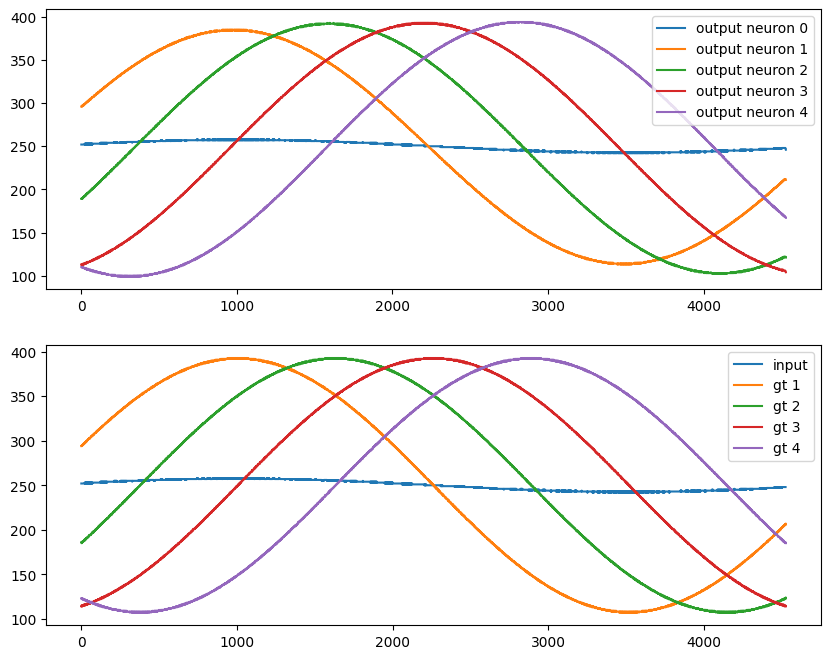

In [16]:
%matplotlib inline
res_resonator = simple_resonator(
    clk_freq=clk_freq,
    freq0=freq0,
    lf=lf,
    thetas=chosen_bias,
    weights=chosen_weights,
)

for i in range(len(res_resonator.neurons)):
    res_resonator.log_out_spikes(i)
res_resonator.input_full_data(sine_wave)

output = [events_to_spikes(neuron_output(neuron, freq0)-resonator_input[0],
                           run_window=spikes_window,
                           spikes_arr_size=int(clk_freq/freq0)+3)
          for neuron in res_resonator.neurons]

fig, axs = plt.subplots(2, 1, figsize=(10, 8))
for i, o in enumerate(output):
    axs[0].plot(o, label=f'output neuron {i}')
axs[0].legend()
axs[1].plot(events_to_spikes(resonator_input-resonator_input[0], run_window=spikes_window), label=f'input')
for i, gt in enumerate(rolling_gt):
    axs[1].plot(gt, label=f'gt {i+1}')

axs[1].legend()

In [24]:
x = np.linspace(0, 360, len(output[0]))
print(f'xi = {x[int(argmax(output[1]))] - x[int(argmax(output[0]))]}')

xi = 1.6595744680851112


# 305.577490736439 ~ peak 308.710 nid 3 snr 12.689
# chosen_bias=[-21.354, -31.528, -29.568, -29.787]
# chosen_weights=[92.829, 50.954, 62.795, 59.249, 59.638]
xi = -1.907705895341138
f0 = 309.4010669982009
f0/2 = 321.24392695050443
Q factor 9.068411722162532, f1 = 288.9378014560223, f2 = 323.056352364121


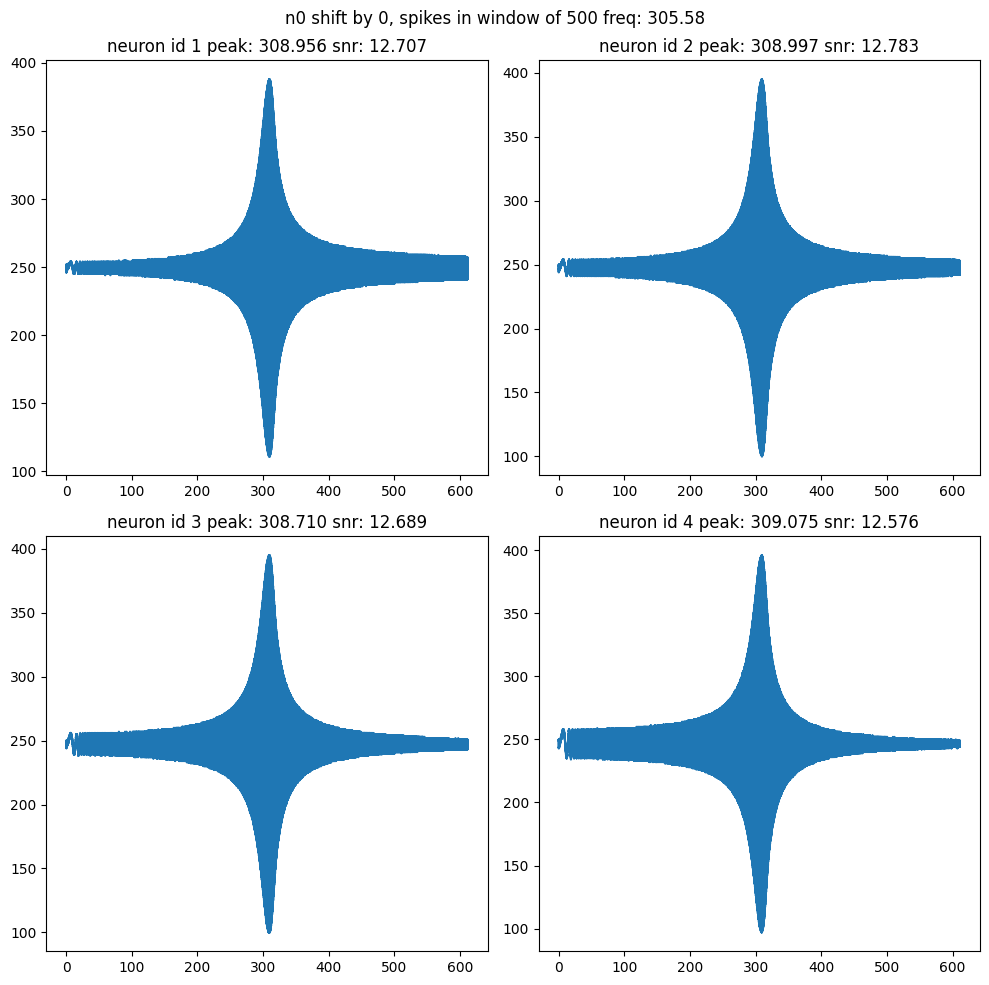

In [17]:
x = np.linspace(0, 360, len(output[0]))
xi = x[int(argmax(output[1]))] - x[int(argmax(output[0]))]
                                            
from snn.resonator import test_resonator_on_chirp, freq_of_resonator
clk_freq = 1_536_000
res_resonator = simple_resonator(
    clk_freq=clk_freq,
    freq0=freq0,
    lf=lf,
    thetas=chosen_bias,
    weights=chosen_weights,
)

for nid in range(1, 5):
    res_resonator.log_out_spikes(nid)

start_freq = 0
spectrum = 2 * freq0
res_resonator.forget_logs()

step = 100/(clk_freq)
test_size = int(spectrum / step)
test_resonator_on_chirp(
    res_resonator,
    start_freq=start_freq,
    step=step,
    test_size=test_size,
    clk_freq=clk_freq
)

snr = [0] * 4
peak = [0] * 4
best_lp = lp_by_lf(lf, freq0, clk_freq)
f_resonator = freq_of_resonator(clk_freq, lf, best_lp)
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f'n0 shift by {phase_shifts[0]}, spikes in window of {spikes_window} freq: {f_resonator:.2f}')
for nid in range(4):
    spikes_neuron = res_resonator.neurons[nid + 1]
    y_events = spikes_neuron.out_spikes()
    y_spikes = np.zeros(test_size)
    y_spikes[y_events] = 1
    y_spikes = np.convolve(y_spikes, np.ones(spikes_window, dtype=int), 'valid')
    x = np.linspace(start_freq, start_freq+spectrum, len(y_spikes))

    ax = axs[nid//2, nid%2]
    # ax.set_ylim(spikes_window/4, 3*spikes_window/4)
    ax.plot(x, y_spikes)
    snr_spikes = y_spikes[3000:]
    snr[nid] = (snr_spikes.max() - snr_spikes.min())/snr_spikes.std()
    peak[nid] = x[3000+np.argmax(snr_spikes)]
    ax.set_title(f'neuron id {nid + 1} peak: {peak[nid]:.3f} snr: {snr[nid]:.3f}')
fig.tight_layout()

nid = np.argmax(np.array(snr) / np.abs(np.array(peak) - freq0))
print(f'# {freq0} ~ peak {peak[nid]:.3f} nid {nid+1} snr {snr[nid]:.3f}')
print(f'# chosen_bias={list(chosen_bias)}')
print(f'# chosen_weights={list(chosen_weights)}')

f0 = x[y_spikes == y_spikes.max()]
f0 = (f0[0] + f0[-1])/2
f2 = np.mean(y_spikes) + .5*(np.max(y_spikes) - np.mean(y_spikes))
arg_Q = x[(y_spikes > f2*.997) & (y_spikes < f2*1.003)]
print(f'xi = {xi}')
print(f'f0 = {f0}')
print(f'f0/2 = {f2}')
print(f'Q factor {f0/(arg_Q[-1] - arg_Q[0])}, f1 = {arg_Q[0]}, f2 = {arg_Q[-1]}')

# Q Factor

<IPython.core.display.Javascript object>


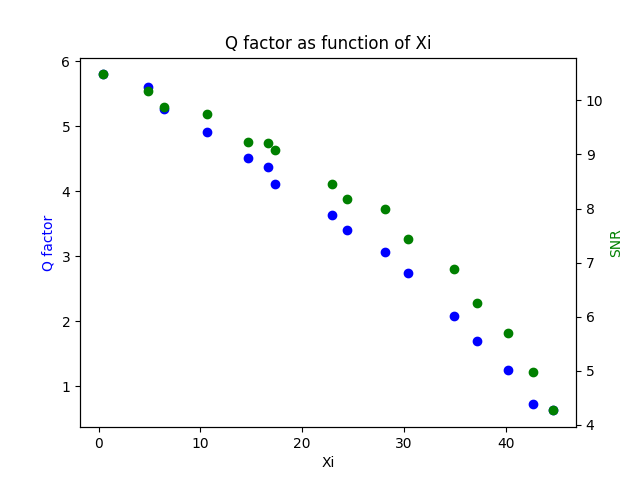

Text(0.5, 1.0, 'Q factor as function of Xi')

In [288]:
%matplotlib notebook
xi = [0.37, 4.85, 6.46, 10.6, 14.68, 16.6, 17.3, 22.9, 24.4, 28.1, 30.4, 34.9, 37.2, 40.2, 42.7, 44.7]
Qs = [5.8, 5.61, 5.26, 4.91, 4.51, 4.38, 4.11, 3.63, 3.4, 3.06, 2.75, 2.08, 1.7, 1.25, 0.73, 0.63]
snrs = [10.480, 10.168, 9.871, 9.746, 9.235, 9.208, 9.079, 8.462, 8.177, 7.988, 7.441, 6.881, 6.256, 5.694, 4.977, 4.268]
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.scatter(xi, Qs, label='Q factor', color='b')
ax2.scatter(xi, snrs, label='snr', color='g')


ax1.set_xlabel('Xi')
ax1.set_ylabel('Q factor', color='b')
ax2.set_ylabel('SNR', color='g')
plt.title('Q factor as function of Xi')


## Weights as function of Xi

<IPython.core.display.Javascript object>


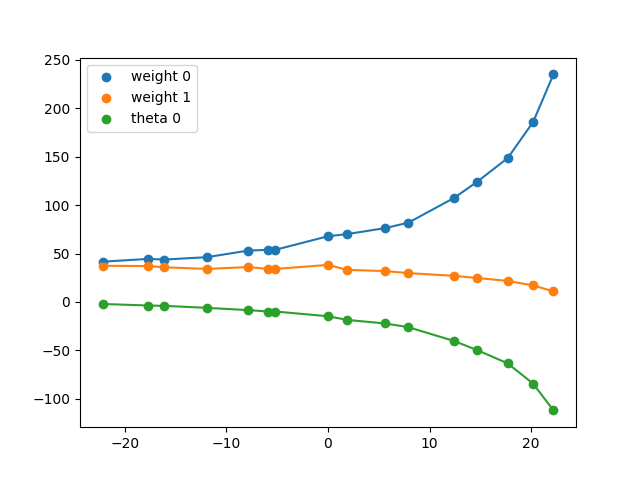

In [76]:
xis = np.array([44.7, 42.7, 40.2, 37.2, 34.9, 30.4, 28.1, 24.4, 22.5, 17.3, 16.6, 14.6, 10.6, 6.4, 4.8, 0.3]) - 22.5
thetas = np.array([
    [-112.06, -21.5, -20.517, -20.663],
    [-84.471, -21.442, -20.521, -20.728],
    [-63.525, -21.398, -20.51, -20.777],
    [-49.822, -21.38, -20.543, -20.789],
    [-40.31, -21.337, -20.523, -20.797],
    [-26.073, -21.301, -20.504, -20.81],
    [-22.22, -20.797, -20.321, -20.808],
    [-18.599, -20.752, -20.18, -20.807],
    [-14.785, -22.158, -16.651, -20.806],
    [-9.895, -21.482, -20.347, -20.591],
    [-9.896, -21.483, -20.349, -20.591],
    [-8.455, -20.563, -20.377, -20.617],
    [-6.14, -21.395, -20.934, -20.772],
    [-4.069, -20.842, -20.888, -20.733],
    [-3.714, -20.503, -20.588, -20.714],
    [-2.115, -20.5, -20.671, -20.734],
])
weights = np.array([
    [235.035, 10.882, 42.655, 41.047, 41.355],
    [185.918, 17.029, 42.551, 41.065, 41.493],
    [148.636, 21.698, 42.643, 41.087, 41.59],
    [124.205, 24.712, 42.563, 41.14, 41.622],
    [107.323, 26.916, 42.484, 41.135, 41.672],
    [81.819, 29.788, 42.529, 41.045, 41.629],
    [76.204, 31.873, 41.482, 40.693, 41.635],
    [70.1, 33.083, 41.376, 40.418, 41.663],
    [67.842, 38.242, 44.196, 33.457, 41.604],
    [53.799, 34.073, 42.899, 40.714, 41.206],
    [53.846, 34.091, 42.951, 40.759, 41.223],
    [52.97, 36.011, 41.175, 40.705, 41.209],
    [46.254, 34.107, 42.725, 41.864, 41.555],
    [43.763, 35.725, 41.621, 41.762, 41.459],
    [44.452, 37.039, 41.031, 41.144, 41.42],
    [41.551, 37.349, 41.039, 41.293, 41.442]
])


for i in range(2):
    fit = Polynomial.fit(xis, weights[:, i], deg=15)
    plt.scatter(xis, weights[:, i], label=f'weight {i}')
    plt.plot(xis, fit(xis))
    

for i in range(1):
    fit = Polynomial.fit(xis, thetas[:, i], deg=15)
    plt.scatter(xis, thetas[:, i], label=f'theta {i}')
    plt.plot(xis, fit(xis))

plt.legend()



In [84]:
a, b ,c = weights[-1, 0]/weights[8, 0], weights[8, 1] / weights[-1, 1], thetas[8, 0] / thetas[-1, 0]
a, 1/b , 1/c

(0.6124672032074526, 0.9766487108414832, 0.1430503889076767)

In [85]:
41.551/67.842

0.6124672032074526

## Improve DC

In [ ]:
np.argmin(mses.mean(axis=1))

In [92]:
from snn.spiking_neuron import BINARY
import os
import json
from snn.resonator import test_resonator_on_chirp, freq_of_resonator

def trained_resonator(freq0, clk_freq, lf=4):
    configured_freq = freq0 * 1_536_000 / clk_freq
    root_folder = f'../filters{lf}/clk_1536000/parameters/'
    available_resonators = np.array([int(f[2:-5]) for f in os.listdir(root_folder)])
    arg_chosen_resonator = np.argmin(np.abs(available_resonators - configured_freq))
    chosen_resonator = available_resonators[arg_chosen_resonator]
    with open(f'{root_folder}/f_{chosen_resonator}.json') as f:
        parameters = json.load(f)
        thetas = parameters['thetas']
        weights = parameters['weights']
    return simple_resonator(freq0, clk_freq, 4, thetas, weights)

clk_freq = 1_536_00
freq0 = 13.5
resonator = trained_resonator(freq0, clk_freq)

neuron = create_SCTN()
neuron.synapses_weights = np.array([3.0])
neuron.leakage_period = np.inf
neuron.theta = -1
neuron.threshold_pulse = 3
neuron.reset_to = 1.5
neuron.activation_function = BINARY

resonator.add_layer(SCTNLayer([neuron]))

# 13.5 ~ peak 13.528 nid 3 snr 9.657


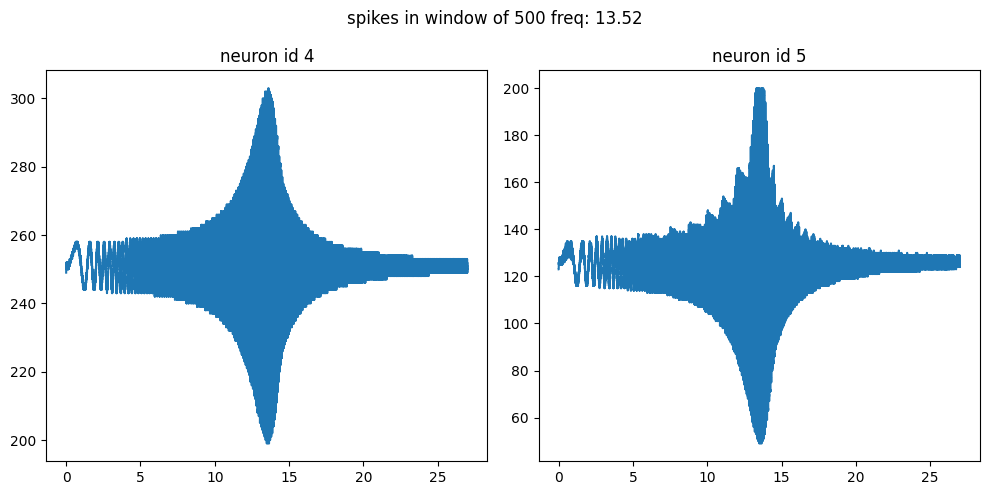

In [93]:
neuronds_id = [4, 5]
for nid in neuronds_id:
    resonator.log_out_spikes(nid)

start_freq = 0
spectrum = 2 * freq0
resonator.forget_logs()

step = 1/clk_freq
test_size = int(spectrum / step)
test_resonator_on_chirp(
    resonator,
    start_freq=start_freq,
    step=step,
    test_size=test_size,
    clk_freq=clk_freq
)

best_lp = lp_by_lf(lf, freq0, clk_freq)
f_resonator = freq_of_resonator(clk_freq, lf, best_lp)
fig, axs = plt.subplots(1, len(neuronds_id), figsize=(10, 5))
fig.suptitle(f'spikes in window of {spikes_window} freq: {f_resonator:.2f}')
for nid in neuronds_id:
    spikes_neuron = resonator.neurons[nid]
    y_events = spikes_neuron.out_spikes()
    y_spikes = np.zeros(test_size)
    y_spikes[y_events] = 1
    y_spikes = np.convolve(y_spikes, np.ones(spikes_window, dtype=int), 'valid')
    x = np.linspace(start_freq, start_freq+spectrum, len(y_spikes))

    ax = axs[nid - neuronds_id[0]]
    ax.plot(x, y_spikes)
    ax.set_title(f'neuron id {nid}')
fig.tight_layout()

nid = np.argmax(np.array(snr) / np.abs(np.array(peak) - freq0))
print(f'# {freq0} ~ peak {peak[nid]:.3f} nid {nid+1} snr {snr[nid]:.3f}')

0